In [1]:
#import required libraries
import tensorflow as tf
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import numpy as np
from IPython.display import display, Image
import csv
import glob
import re
from linreg_nn import *
from sketch_dec import SketchRNNDecoder
from draw_utils import plot_stroke

In [2]:
sketch_vec = "owl_z.csv"    #shape 100,128
photo_vec = "photo_z.csv"   # shape 100,7,7,160
# photo_dir = "/home/kelvin/OgataLab/sketch-wmultiple-tags/rendered_256x256/256x256/photo/tx_000000000000/owl/"
photo_dir = "/home/kelvin/OgataLab/sketch-wmultiple-tags/dataset/photos/elephant/"
MODEL_DIR = "./linreg_log/test_elepig2"
# MODEL_DIR = "./linreg_log/test4"#log for pseudo inverse training

# inputs, targets = get_csv_dataset()
# test_in = inputs[-5:]
# test_tar = targets[-5:]
# inp,targ = test_in, test_tar
"""load from npz"""
npz_dir = "./dataset/"
elepig = np.load(npz_dir+"elephantpig.npz")
# test
inp = elepig['test_photo']
targ = elepig['test_sketch']

In [3]:
#load photos

# img_n = list(range(1,101))
# img_arr = []
# for i in range(len(img_n)):
#     img_arr.append(photo_dir+str(img_n[i])+'.jpg')
img_arr = glob.glob(photo_dir+'/*.jpg')
img_arr = sorted(img_arr, key=lambda x: int(re.search(r'(?<=_)\w+', x).group()))
tar_p = img_arr[9:14]
# print(tar_p)
# for i in range(len(tar_p)):
#     display(Image(filename=tar_p[i]))

In [4]:
#function to show images horizontally
def HoriImages(img_array):
    fig = plt.figure()
    file_no = len(img_array)
    for i in range(file_no):
        a=fig.add_subplot(1,file_no,i+1)
        image = plt.imread(img_array[i])
        plt.imshow(image)
        plt.axis('off')

In [5]:
#load predictions from linear model
my_feature_columns = [tf.feature_column.numeric_column(
        key="x",
        shape=[7 * 7 * 160]
    )]    

my_config = tf.estimator.RunConfig(model_dir=MODEL_DIR)

# create a linear regression model
model = tf.estimator.Estimator(
        model_fn=linreg_fn,
        params={
            'feature_columns': my_feature_columns,
        },
        config=my_config
    )

pred_input_fn = tf.estimator.inputs.numpy_input_fn(
        x={'x': inp},
        y=targ,
        batch_size=BATCH_SIZE,
        shuffle=False,
        num_epochs=1
    )
preds = model.predict(input_fn=pred_input_fn)

INFO:tensorflow:Using config: {'_save_checkpoints_secs': 600, '_session_config': None, '_keep_checkpoint_max': 5, '_tf_random_seed': None, '_task_type': 'worker', '_is_chief': True, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x7f23c0c85490>, '_model_dir': './linreg_log/test_elepig2', '_num_worker_replicas': 1, '_task_id': 0, '_log_step_count_steps': 100, '_master': '', '_save_checkpoints_steps': None, '_keep_checkpoint_every_n_hours': 10000, '_service': None, '_save_summary_steps': 100, '_num_ps_replicas': 0}


In [6]:
#call decoder
decoder = SketchRNNDecoder("/tmp/sketch_rnn/models/elephantpig/lstm_test/")

INFO:tensorflow:Model using cpu.
INFO:tensorflow:Input dropout mode = 0.
INFO:tensorflow:Output dropout mode = 0.
INFO:tensorflow:Recurrent dropout mode = 0.
INFO:tensorflow:Loading model /tmp/sketch_rnn/models/elephantpig/lstm_test/vector.
INFO:tensorflow:Restoring parameters from /tmp/sketch_rnn/models/elephantpig/lstm_test/vector


In [7]:
#place vectors into list
stroke_t = []
stroke_p = []
for i in range(len(targ)):
    stroke_t.append(decoder.draw_from_z(np.expand_dims(targ[i],0)))
for pred in preds:
    stroke_p.append(decoder.draw_from_z(np.expand_dims(pred['sketch_vector'],0)))

INFO:tensorflow:Restoring parameters from ./linreg_log/test_elepig2/model.ckpt-100000


In [8]:
#Reconstruction display definition
def reconst(row, col, strokes):
    fig = plt.figure()
    gs = gridspec.GridSpec(row, col)
    c=0
    for i in range(row):
        for j in range(col):
            ax = fig.add_subplot(gs[i, j])
            plot_stroke(ax, strokes[c])
            c+=1
    plt.show()

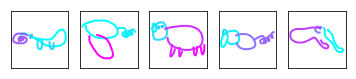

In [9]:
#Reconstruction results from targets
# for i in range(len(stroke_t)):
#     ax = plt.subplot(111)
#     plot_stroke(ax,stroke_t[i])
#     plt.show()
reconst(1,5,stroke_t)

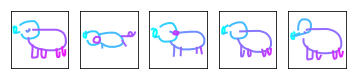

In [10]:
#Reconstruction results from predictions
reconst(1,5,stroke_p)

In [11]:
HoriImages(tar_p)
print("Untrained Photo targets")
# fig = plt.figure()

Untrained Photo targets


Reconstruction from targets


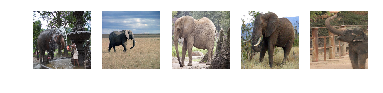

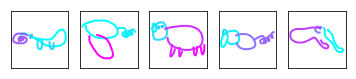

Reconstruction from predictions


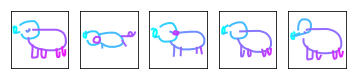

In [12]:
print("Reconstruction from targets")
reconst(1,5,stroke_t)
print("Reconstruction from predictions")
reconst(1,5,stroke_p)